In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import theano.tensor.slinalg as sla
from pymc3.distributions.transforms import t_stick_breaking
from pymc3 import math as pmmath


In [2]:
# recurrent models with sequences of mixed lengths
#import keras
#preproc_seqs = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len_seq,padding='post')
# https://github.com/keras-team/keras/issues/40

# anotherw way to deal with variable lengths?
# https://docs.pymc.io/notebooks/PyMC3_tips_and_heuristic.html
    


In [3]:
# Create probability distrbutions for sampling...
# These are probability distributions to be inferred
L = 5
N = 10
num_cluster = 3
num_values = 3

pi = pm.Dirichlet.dist(a=np.ones(num_cluster),shape=(num_cluster)).random()

theta_i = pm.Dirichlet.dist(a=pm.floatX((1.0 / num_values) * np.ones((num_values))),
                     shape=(num_cluster,num_values)).random()

theta_t = pm.Dirichlet.dist(a=pm.floatX((1.0 / num_values) * np.ones((num_values))),
                     shape=(num_cluster,num_values,num_values)).random()


In [4]:

data = []
clusters = []
for d in range(N):
    # draw a cluster
    #cluster = np.random.choice(num_cluster,p=pi)
    cluster = pm.Categorical.dist(pi).random(size=1)[0]
    values = []
    # draw initial value 
    #prev_value = np.random.choice(num_cluster,p=theta_i[cluster])
    prev_value = pm.Categorical.dist(theta_i[cluster]).random(size=1)[0]
    values.append(prev_value)
    for l in range(L-1):
        # draw next value based on previous value
        #next_value = np.random.choice(num_cluster,p=theta_t[cluster,prev_value])
        next_value = pm.Categorical.dist(theta_t[cluster,prev_value]).random(size=1)[0]
        values.append(prev_value)
        prev_value = next_value
    data.append(values)
    clusters.append(cluster)

print data
print clusters

[[2, 2, 0, 1, 2], [0, 0, 0, 2, 0], [1, 1, 2, 0, 2], [2, 2, 0, 1, 2], [1, 1, 2, 2, 1], [2, 2, 1, 2, 0], [2, 2, 0, 1, 2], [2, 2, 0, 0, 0], [0, 0, 1, 2, 2], [2, 2, 0, 1, 2]]
[1, 0, 1, 2, 2, 1, 1, 2, 1, 1]


In [6]:
data = np.matrix(data)
data

matrix([[2, 2, 0, 1, 2],
        [0, 0, 0, 2, 0],
        [1, 1, 2, 0, 2],
        [2, 2, 0, 1, 2],
        [1, 1, 2, 2, 1],
        [2, 2, 1, 2, 0],
        [2, 2, 0, 1, 2],
        [2, 2, 0, 0, 0],
        [0, 0, 1, 2, 2],
        [2, 2, 0, 1, 2]])

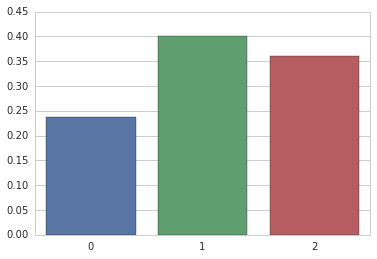

In [7]:
import seaborn as sns
sns.set(style="whitegrid")
sns.barplot(x=range(3),y=pi)

In [8]:
theta_i

array([[9.96304644e-01, 4.86562792e-10, 3.69535567e-03],
       [6.13317722e-03, 8.67823234e-03, 9.85188590e-01],
       [4.16230824e-03, 3.37526863e-01, 6.58310829e-01]])

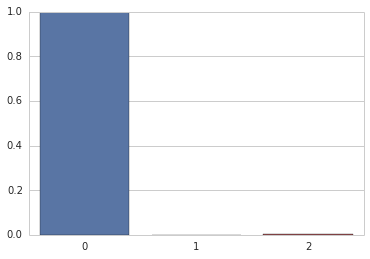

In [9]:
# initial probabilities for cluser 0
sns.barplot(x=range(num_values),y=theta_i[0])

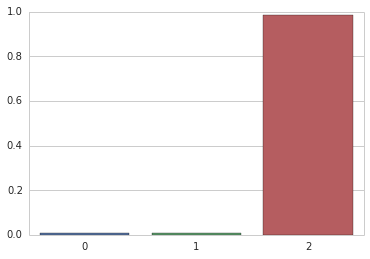

In [10]:
# initial probabilities for cluster 1
sns.barplot(x=range(num_values),y=theta_i[1])

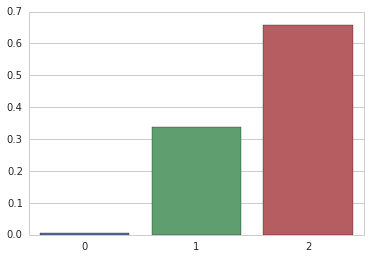

In [11]:
# initial probabilities for cluser 2
sns.barplot(x=range(num_values),y=theta_i[2])

In [12]:
# assignments
clusters

[1, 0, 1, 2, 2, 1, 1, 2, 1, 1]

In [ ]:
def log_data(pi,theta_init,theta_trans):
    def log_data_(docs):
        # use tensor flow computation...
        l_data = 0
        for idx in range(len(data)):
            l_obs = []
            for pidx in range(len(pi)):
                l_obs.append(log(pi[pidx]) + log(theta_init[pidx][data[idx,0]]) +\
                    sum(logp(theta_init[pidx,data[:-1]][data[idx,1:]])))
            l_data.append(logsumexp(l_obs))
        return sum(l_data)
    
    return log_data_

In [ ]:
num_clusters = 3

with pm.Model() as model:   
    pi = pm.Dirichlet("pi", a=np.ones(1), shape=1)
    # the posterior distribution of a multinomial with a dirichlet prior is another dirichlet prior
    #pi = [pm.Dirichlet('pi_%d' % i, a=pm.floatX((1.0 / num_clusters) * np.ones(1)), shape=(1)) for i in range(num_clusters)]
    theta_t =  [pm.Dirichlet('theta_t_%d' % idx, a=pm.floatX((1.0 / num_values) * np.ones((num_values, num_values))),
                     shape=(num_values, num_values), transform=t_stick_breaking(1e-9)) for idx in range(num_clusters)]

In [ ]:
np.ones((1))

In [ ]:
with pm.Model() as model:   
    pi = pm.Dirichlet("pi", a=np.ones(1), shape=1)

In [ ]:
L = 5
N = 10
num_cluster = 3
num_values = 3

pi = pm.Dirichlet.dist(a=np.ones(num_cluster),shape=(num_cluster)).random()

theta_i = pm.Dirichlet.dist(a=pm.floatX((1.0 / num_values) * np.ones((num_values))),
                     shape=(num_cluster,num_values)).random()

theta_t = pm.Dirichlet.dist(a=pm.floatX((1.0 / num_values) * np.ones((num_values))),
                     shape=(num_cluster,num_values,num_values)).random()

In [ ]:
theta_i

In [ ]:
theta_t


In [ ]:
theta_init = theta_i
theta_trans = theta_t

In [ ]:
from scipy.misc import logsumexp 
import numpy as np

l_data = []
for didx in range(len(data)):
    l_obs = []
    for pidx in range(len(pi)):
        l_obs.append(np.log(pi[pidx]) + np.log(theta_init[pidx][data[didx][0]]) +\
                    np.sum(np.log(theta_trans[pidx,data[didx][:-1]][data[didx][1:]])))
    l_data.append(logsumexp(l_obs))
np.sum(l_data)
            
            
# sum across rows   
#sreturn np.sum(logsumexp(tt.stacklists(logps), axis=0))

In [ ]:
## what about doing it with tensors??


In [ ]:



pi = pi.astype('float32')
#ttheta_init = 
#ttheta_trans = 
x = tt.fvector('x')
s = tt.sum(x)

In [ ]:
## trying theano sum 
l_data = []
for didx in range(len(data)):
    l_obs = []
    for pidx in range(len(pi)):
        l_obs.append(np.log(pi[pidx]) + np.log(theta_init[pidx][data[didx][0]]) +\
                    np.sum(np.log(theta_trans[pidx,data[didx][:-1]][data[didx][1:]])))
    l_data.append(logsumexp(l_obs))
np.sum(l_data)



In [ ]:
tt._shared(np.array(data))

In [ ]:
data = np.matrix(data)
d = tt.imatrix('d')
theta = tt.fvector('theta')
s = np.concatenate(theta[d[:,0]])
f = theano.function([d,theta], )

In [ ]:
f(np.array(data).astype('int32'),theta_i.astype('float32'))

In [ ]:
theta_i

In [ ]:
### log(\theta) 
np.concatenate(theta_i[data[:,0]])

In [ ]:
# log(theta_i)
np.concatenate(theta_i[data[:,0]])

In [ ]:
# equivalent in theano
theano.config.on_unused_input='ignore'

data = np.matrix(data)
d = tt.imatrix('d')
theta = tt.fmatrix('theta')
out = theta[d[:,0]]
f = theano.function([d,theta], out)
f(data.astype('int32'),theta_i.astype('float32'))

In [ ]:
# log(pi)+log(theta_i) 
pi + np.concatenate(theta_i[data[:,0]])

In [ ]:
# equivalent in theano
data = np.matrix(data)
td = tt.imatrix('td')
ttheta = tt.fmatrix('ttheta')
tpi = tt.fvector('tpi')
out = tpi + ttheta[td[:,0]]
f = theano.function([td,ttheta,tpi], out)
f(data.astype('int32'),theta_i.astype('float32'),pi)

In [ ]:
theta_t[1]

In [ ]:
#  np.sum(np.log(theta_trans[pidx,data[didx][:-1]][data[didx][1:]])))
#theta_t[data[:,:-1]][data[:,1:]][0]
theta_t

In [ ]:
# theta for K=0 to go from t-1=1 to t=2
theta_t[:][0,0]

In [ ]:
theta_trans[0][1,1]

In [ ]:
theta_t[0][data[1,:-1],data[1,1:]]

In [ ]:
theta_t

In [ ]:
theta_t[data[:,:-1],data[:,1:]]

In [ ]:
theta_t

In [ ]:
data = np.matrix(data)
tdata = tt.imatrix('tdata')
ttheta_i = tt.fmatrix('ttheta_i')
ttheta_t = tt.tensor3('ttheta_t')
tpi = tt.fvector('tpi')
out = ttheta_t[tdata[:,:-1]][tdata[:,1:]]
f = theano.function([tdata,ttheta_i,ttheta_t,tpi], out)
ret = f(data.astype('int32'),theta_i.astype('float32'),theta_t.astype('float32'),pi)

In [ ]:
len(ret)

In [ ]:
ret[0][1]

In [ ]:
theta_trans.shape

In [ ]:
theta_t

In [ ]:
theta_trans[0][data[1,:-1],data[1,1:]]

In [ ]:
theta_trans[0]

In [ ]:
data[1]

In [ ]:
theta_trans[:][data[1,:-1],data[1,1:]]

In [ ]:
theta_trans

In [ ]:
data[1,:-1],data[1,1:]

In [ ]:
##### make things a bit simpler. let's assume we can iterate by cluster 
# this is the sum for one cluster...
np.stack([np.sum(theta_trans[i][data[:,:-1],data[:,1:]],axis=1) for i in range(3)])

In [ ]:
## this is the computation in numpy
np.stack([np.sum(theta_trans[i][data[:,:-1],data[:,1:]],axis=1) for i in range(3)]).T

In [ ]:
data

In [15]:
#### TESTS START HERE
from scipy.misc import logsumexp 

# Compute log(pi) with loops
l_data = []
for didx in range(len(data)):
    l_obs = [np.log(pi[pidx]) for pidx in range(len(pi))]
    l_data.append(logsumexp(l_obs))
np.sum(l_data)

/Users/bieljoanisaac/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  


-1.1102230246251565e-15

In [16]:
# Compute log(pi) with numpy
l_data = logsumexp(np.log(pi)*np.ones((10,1)),
                   axis=1)
np.sum(l_data)

/Users/bieljoanisaac/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


-1.1102230246251565e-15

In [18]:
# Compute log(\theta^I) with loops
l_data = []
for didx in range(len(data)):
    l_obs = [(np.log(theta_i[pidx][data[didx,0]])) for pidx in range(len(pi))]
    #l_obs = [(theta_init[pidx][data[didx,0]]) for pidx in range(len(pi))]
    print l_obs
    #l_data.append(l_obs)
    #print logsumexp(l_obs)
    l_data.append(logsumexp(l_obs))
#print l_data
np.sum(l_data)

[-5.60067847345571, -0.014922193769395724, -0.41807807455196755]
[-0.003702200847730512, -5.094042355918011, -5.481685493584969]
[-21.4436551536598, -4.746937418056809, -1.0861101787517167]
[-5.60067847345571, -0.014922193769395724, -0.41807807455196755]
[-21.4436551536598, -4.746937418056809, -1.0861101787517167]
[-5.60067847345571, -0.014922193769395724, -0.41807807455196755]
[-5.60067847345571, -0.014922193769395724, -0.41807807455196755]
[-5.60067847345571, -0.014922193769395724, -0.41807807455196755]
[-0.003702200847730512, -5.094042355918011, -5.481685493584969]
[-5.60067847345571, -0.014922193769395724, -0.41807807455196755]


/Users/bieljoanisaac/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  if __name__ == '__main__':


0.8861512804341987

In [19]:
## Compute log(\theta^I) with numpy
l_data = logsumexp(np.column_stack(np.log(theta_i[:,data[:,0]])),
                   axis=1)
print l_data
np.sum(l_data)

[ 0.4990737   0.00657844 -1.06072392  0.4990737  -1.06072392  0.4990737
  0.4990737   0.4990737   0.00657844  0.4990737 ]


/Users/bieljoanisaac/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


0.8861512804341987

In [21]:
# Compute log(\theta^T) with loops
l_data = []
for didx in range(len(data)):
    l_obs = []
    for pidx in range(3):
        trans = []
        for iidx in range(data[didx].shape[1]-1):
            #trans.append(np.log(theta_trans[pidx][data[didx,iidx],data[didx,iidx+1]]))  
            trans.append(theta_t[pidx][data[didx,iidx],data[didx,iidx+1]])
            #print "(%d,%d)" % (data[didx,iidx],data[didx,iidx+1])
        #print trans
        l_obs.append(np.sum(trans))
        #print l_obs
    l_data.append(logsumexp(l_obs))
#print l_data
#print l_data
np.sum(l_data)

/Users/bieljoanisaac/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  


28.506023355226496

In [23]:
l_obs  = logsumexp(np.sum(theta_t[:,data[:,:-1],data[:,1:]],axis=2).T,axis=1)
np.sum(l_obs)

/Users/bieljoanisaac/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  """Entry point for launching an IPython kernel.


28.506023355226496

In [24]:
# Compute log(\theta^T) with loops
l_data = []
for didx in range(len(data)):
    l_obs = []
    for pidx in range(3):
        trans = []
        for iidx in range(data[didx].shape[1]-1):
            trans.append(theta_t[pidx][data[didx,iidx],data[didx,iidx+1]])
        l_obs.append(np.log(pi[pidx]) + np.log(theta_i[pidx][data[didx,0]]) + np.sum(trans))
    
    l_data.append(logsumexp(l_obs))
np.sum(l_data)

/Users/bieljoanisaac/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  # This is added back by InteractiveShellApp.init_path()


7.828259829906427

In [47]:
# Compute log(pi) with numpy
l_obs  = logsumexp(np.log(pi)*np.ones((10,1)) + np.column_stack(np.log(theta_i[:,data[:,0]])) + np.sum(np.log(theta_t[:,data[:,:-1],data[:,1:]]),axis=2).T,axis=1)
np.sum(l_obs)

/Users/bieljoanisaac/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  


-63.82716625546157

In [26]:
### same implementation in theano
import theano
import theano.tensor as tt
import theano
theano.config.compute_test_value = "ignore"
theano.config.on_unused_input='ignore'

data = np.matrix(data)
tdata = tt.imatrix('tdata')
ttheta_i = tt.fmatrix('ttheta_i')
ttheta_t = tt.tensor3('ttheta_t')
tpi = tt.fvector('tpi')

In [27]:
#out = tt.sum(pmmath.logsumexp(tt.log(tpi),axis=1))
out = tt.sum(pmmath.logsumexp(tt.log(tpi)*tt.ones((10,1)),axis=1))
f = theano.function([tpi], out)
f(pi.astype("float32"))

array(1.06936645e-07)

In [28]:
## for some reason, logsumexp is different for pmmath and numpy
l_data = logsumexp(np.log(pi.astype("float32"))*np.ones((10,1)),axis=1)
np.sum(l_data)

/Users/bieljoanisaac/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  


1.0693664509453527e-07

In [32]:
out = tt.sum(pmmath.logsumexp(tt.log(ttheta_i[:,tdata[:,0]]).T,axis=1))
#out = tt.log(ttheta_i[:,tdata[:,0]]).T
f = theano.function([ttheta_i,tdata], out)
f(theta_i.astype("float32"),data.astype("int32"))





array(0.8861511, dtype=float32)

In [33]:
l_data  = logsumexp(np.column_stack(np.log(theta_i.astype("float32")[:,data[:,0]])),axis=1)
np.sum(l_data)

/Users/bieljoanisaac/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  """Entry point for launching an IPython kernel.


0.8861516

In [34]:
logsumexp(np.column_stack(np.log(theta_i.astype("float32")[:,data[:,0]])),axis=1)

/Users/bieljoanisaac/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  """Entry point for launching an IPython kernel.


array([ 0.49907377,  0.00657842, -1.0607239 ,  0.49907377, -1.0607239 ,
        0.49907377,  0.49907377,  0.49907377,  0.00657842,  0.49907377],
      dtype=float32)

In [45]:
#out = tt.sum(pmmath.logsumexp(np.sum(ttheta_t[:,tdata[:,:-1],tdata[:,1:]],axis=2).T,axis=1))
out = tt.sum(pmmath.logsumexp(tt.sum(tt.log(ttheta_t[:,tdata[:,:-1],tdata[:,1:]]),axis=2).T,axis=1))
f = theano.function([ttheta_t,tdata], out)
f(theta_t.astype("float32"),data.astype("int32"))

array(-35.07990157)

In [42]:
l_data  = logsumexp(np.sum(theta_t[:,data[:,:-1],data[:,1:]],axis=2).T,axis=1)
np.sum(l_data)

/Users/bieljoanisaac/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  """Entry point for launching an IPython kernel.


28.506023355226496

In [46]:
### problem logsumexp, in numpy converts single element [x] out of a sum, as an element.
### numpy python keeps pmmath keeps it. In a way that 
out = tt.sum(pmmath.logsumexp(tt.log(tpi)*tt.ones((10,1))+\
                              tt.log(ttheta_i[:,tdata[:,0]]).T+\
                              tt.sum(tt.log(ttheta_t[:,tdata[:,:-1],tdata[:,1:]]),axis=2).T
                              ,axis=1))
f = theano.function([tpi,ttheta_i,ttheta_t,tdata], out)
f(pi.astype("float32"),theta_i.astype("float32"),theta_t.astype("float32"),data.astype("int32"))


array(-63.82716633)

In [49]:
def log_data(pi,theta_init,theta_trans):
    def log_data_(docs):
        t1 = tt.log(pi)*tt.ones((10,1))
        t2 = tt.log(theta_init[:,docs[:,0]]).T
        t3 = tt.sum(theta_trans[:,docs[:,:-1],docs[:,1:]],axis=2).T
        return tt.sum(pmmath.logsumexp(t1+t2+t3,axis=1))
    
    return log_data_

In [50]:
num_clusters = 3
with pm.Model() as model:   
    # the posterior distribution of a multinomial with a dirichlet prior is another dirichlet prior
    pi = pm.Dirichlet('pi', a=pm.floatX((1.0 / num_clusters) * np.ones(num_clusters)),
                      shape=(num_clusters),transform=t_stick_breaking(1e-9))
    theta_i = pm.Dirichlet('theta_i', a=pm.floatX((1.0 / num_values) * np.ones((num_clusters,num_values))),
                     shape=(num_clusters, num_values), transform=t_stick_breaking(1e-9))
   
    theta_t =  pm.Dirichlet('theta_t', a=pm.floatX((1.0 / num_values) * np.ones((num_clusters,num_values, num_values))),
                     shape=(num_clusters,num_values, num_values), transform=t_stick_breaking(1e-9))
    # how do we aggregate the likelihood of all the data
    obs = pm.DensityDist('obs', log_data(pi, theta_i, theta_t), observed=data)
    
    #start = pm.find_MAP(fmin=optimize.fmin_powell)
    ##step1 = pm.Metropolis(vars=[P,A,S,PA,emission])
    #step2 = pm.CategoricalGibbsMetropolis(vars=[states])
    #trace = pm.sample(10000, start=start, step=[step1,step2],njobs=1)

TypeError: index must be integers